In [1]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_model,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from PIL import Image


%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"

In [3]:
def distance(row,cluster_center,z_col_names):
    return norm(row[z_col_names].values - cluster_center)

In [4]:
def plot_number_of_samples_vs_label(cluster_group, title_string):
    for cluster in cluster_group:
        cluster_num = cluster.id
        cluster_details = cluster.details
        _df = cluster_details["cluster_data_frame"]
        fig = plt.figure(figsize=(20, 8))
        #fig.tight_layout()
        plt.title(title_string.format(cluster_group_name, cluster_num),fontsize=22)
        plt.xlabel("Label")
        plt.ylabel("Number of samples")
        number_of_samples_for_label = get_pmf_y_given_z(_df, "label", exp_config.Z_DIM, normalized=False)
        plt.bar(x=number_of_samples_for_label.index.values + 0.5,
                height=number_of_samples_for_label,
                width=0.8, align="center")
        plt.text(0.22, 0.84, "Manual Label : {},{}".format(manual_labels[cluster_num], manual_confidence[cluster_num]),
                bbox=dict(facecolor='red', alpha=0.5),
                transform=fig.transFigure)
        plt.xticks(number_of_samples_for_label.index.values + 0.5, number_of_samples_for_label.index.values)
        plt.ylim(0, max(number_of_samples_for_label) * 1.1) 
        plt.grid(which="major", axis="x")

In [5]:
def cluster_next_level(df, processed_clusters = [],
                       cluster_column_name_2 = cluster_column_name_2,
                       cluster_type = "unknown_cluster"):
    if cluster_type in cluster_group_dict.keys():
        for cluster in cluster_group_dict[cluster_type]:
            print(cluster.id)
            if cluster.id in processed_clusters:
                continue
            _indices =np.where( cluster_labels == cluster.id)
            _df = df.iloc[_indices]

            _latent_vectors = _df[z_col_names].values
            tf.reset_default_graph()
            _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                                   10,
                                                                                                   _latent_vectors,
                                                                                                   exp_config,
                                                                                                   dao
                                                                                                  )
            df[cluster_column_name_2].iloc[_indices] = _cluster_labels
            image_filename = exp_config.ANALYSIS_PATH+f"cluster_centers__level_2_epoch_{epochs_completed}_cluster_id_{cluster.id}.png"

            display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

            return cluster, _cluster_centers, _cluster_labels
    return None, None, None
    

# Set experiment parameters

In [6]:
z_dim = 10
run_id = 30
experiment_name = "semi_supervised_classification"
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

In [7]:
z_dim = 10
run_id = 30
experiment_name = "semi_supervised_classification"
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

exp_config = ExperimentConfig(root_path=ROOT_PATH,
                               num_decoder_layer=4,
                               z_dim=z_dim,
                               num_units=num_units,
                               num_cluster_config=num_cluster_config,
                               confidence_decay_factor=5,
                               beta=5,
                               supervise_weight=150,
                               dataset_name="mnist",
                               split_name="Split_1",
                               model_name="VAE",
                               batch_size=64,
                               eval_interval_in_epochs=1,
                               name=experiment_name,
                               num_val_samples=128,
                               total_training_samples=60000,
                               manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                               reconstruction_weight=1,
                               activation_hidden_layer="RELU",
                               activation_output_layer="SIGMOID")
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [8]:
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

# Train model

# Initialize Manual confidence and Manual label for all training examples to 0
# for all i in range(n)
#    m_l[i] =0
#    m_c[i] = 0
#


In [9]:
num_epochs = 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
train_val_data_iterator, exp_config, model = initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
                                       )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'RUN_ID': 30, 'ID': 1, 'name': 'semi_supervised_classification'}
Warning /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_30/analysis/manual_annotation_epoch_0.csv path does not exist. Creating random prior with

Epoch: 0/46, Nll_loss : 232.37161254882812 KLD:1.0083892345428467  Supervised loss:0.0
Epoch: 0/47, Nll_loss : 209.147216796875 KLD:1.306540608406067  Supervised loss:0.0
Epoch: 0/48, Nll_loss : 205.95352172851562 KLD:1.274415135383606  Supervised loss:0.0
Epoch: 0/49, Nll_loss : 213.78933715820312 KLD:1.1518447399139404  Supervised loss:0.0
Epoch: 0/50, Nll_loss : 211.09658813476562 KLD:1.0870875120162964  Supervised loss:0.0
Epoch: 0/51, Nll_loss : 213.40573120117188 KLD:0.9440727829933167  Supervised loss:0.0
Epoch: 0/52, Nll_loss : 205.70657348632812 KLD:0.9843704700469971  Supervised loss:0.0
Epoch: 0/53, Nll_loss : 209.80657958984375 KLD:1.050215721130371  Supervised loss:0.0
Epoch: 0/54, Nll_loss : 215.96429443359375 KLD:1.1164326667785645  Supervised loss:0.0
Epoch: 0/55, Nll_loss : 217.58285522460938 KLD:1.0541815757751465  Supervised loss:0.0
Epoch: 0/56, Nll_loss : 219.53700256347656 KLD:0.9892410039901733  Supervised loss:0.0
Epoch: 0/57, Nll_loss : 224.09844970703125 KLD:0

Epoch: 0/143, Nll_loss : 182.44635009765625 KLD:2.964123487472534  Supervised loss:0.0
Epoch: 0/144, Nll_loss : 183.15554809570312 KLD:2.4444162845611572  Supervised loss:0.0
Epoch: 0/145, Nll_loss : 180.2603302001953 KLD:2.3494863510131836  Supervised loss:0.0
Epoch: 0/146, Nll_loss : 178.01609802246094 KLD:2.503070592880249  Supervised loss:0.0
Epoch: 0/147, Nll_loss : 184.190185546875 KLD:2.585906982421875  Supervised loss:0.0
Epoch: 0/148, Nll_loss : 185.8057098388672 KLD:2.8502485752105713  Supervised loss:0.0
Epoch: 0/149, Nll_loss : 178.58335876464844 KLD:2.568049430847168  Supervised loss:0.0
Epoch: 0/150, Nll_loss : 185.53634643554688 KLD:2.8210642337799072  Supervised loss:0.0
Epoch: 0/151, Nll_loss : 173.1538848876953 KLD:2.8491744995117188  Supervised loss:0.0
Epoch: 0/152, Nll_loss : 175.675048828125 KLD:2.7234978675842285  Supervised loss:0.0
Epoch: 0/153, Nll_loss : 177.8645782470703 KLD:2.621605157852173  Supervised loss:0.0
Epoch: 0/154, Nll_loss : 180.8632049560547 KL

Epoch: 0/238, Nll_loss : 157.33822631835938 KLD:3.993893623352051  Supervised loss:0.0
Epoch: 0/239, Nll_loss : 158.68594360351562 KLD:4.144509315490723  Supervised loss:0.0
Epoch: 0/240, Nll_loss : 155.955810546875 KLD:4.169180870056152  Supervised loss:0.0
Epoch: 0/241, Nll_loss : 159.57125854492188 KLD:4.310108184814453  Supervised loss:0.0
Epoch: 0/242, Nll_loss : 158.92466735839844 KLD:4.40797233581543  Supervised loss:0.0
Epoch: 0/243, Nll_loss : 152.62916564941406 KLD:4.170216083526611  Supervised loss:0.0
Epoch: 0/244, Nll_loss : 162.6250457763672 KLD:4.1740498542785645  Supervised loss:0.0
Epoch: 0/245, Nll_loss : 166.13189697265625 KLD:3.9701364040374756  Supervised loss:0.0
Epoch: 0/246, Nll_loss : 169.42156982421875 KLD:3.839205503463745  Supervised loss:0.0
Epoch: 0/247, Nll_loss : 163.8624267578125 KLD:3.960181713104248  Supervised loss:0.0
Epoch: 0/248, Nll_loss : 162.2145233154297 KLD:3.6325082778930664  Supervised loss:0.0
Epoch: 0/249, Nll_loss : 154.80282592773438 KL

Epoch: 0/333, Nll_loss : 158.63661193847656 KLD:4.623577117919922  Supervised loss:0.0
Epoch: 0/334, Nll_loss : 158.06301879882812 KLD:4.37797212600708  Supervised loss:0.0
Epoch: 0/335, Nll_loss : 157.24191284179688 KLD:4.133327960968018  Supervised loss:0.0
Epoch: 0/336, Nll_loss : 154.1272735595703 KLD:4.365541934967041  Supervised loss:0.0
Epoch: 0/337, Nll_loss : 156.60801696777344 KLD:4.40161657333374  Supervised loss:0.0
Epoch: 0/338, Nll_loss : 153.76242065429688 KLD:4.358895301818848  Supervised loss:0.0
Epoch: 0/339, Nll_loss : 168.78469848632812 KLD:4.41843843460083  Supervised loss:0.0
Epoch: 0/340, Nll_loss : 156.61688232421875 KLD:4.529325485229492  Supervised loss:0.0
Epoch: 0/341, Nll_loss : 145.53839111328125 KLD:4.972187519073486  Supervised loss:0.0
Epoch: 0/342, Nll_loss : 147.88729858398438 KLD:4.597560882568359  Supervised loss:0.0
Epoch: 0/343, Nll_loss : 146.74362182617188 KLD:4.651745796203613  Supervised loss:0.0
Epoch: 0/344, Nll_loss : 164.45330810546875 KLD

Epoch: 0/429, Nll_loss : 157.83932495117188 KLD:4.433039665222168  Supervised loss:0.0
Epoch: 0/430, Nll_loss : 153.94140625 KLD:4.58881950378418  Supervised loss:0.0
Epoch: 0/431, Nll_loss : 144.90573120117188 KLD:4.422257423400879  Supervised loss:0.0
Epoch: 0/432, Nll_loss : 152.3917236328125 KLD:4.702020168304443  Supervised loss:0.0
Epoch: 0/433, Nll_loss : 153.50927734375 KLD:5.245140075683594  Supervised loss:0.0
Epoch: 0/434, Nll_loss : 144.12258911132812 KLD:5.278567314147949  Supervised loss:0.0
Epoch: 0/435, Nll_loss : 143.5953369140625 KLD:5.414684772491455  Supervised loss:0.0
Epoch: 0/436, Nll_loss : 150.36898803710938 KLD:5.705042839050293  Supervised loss:0.0
Epoch: 0/437, Nll_loss : 156.49049377441406 KLD:5.393087387084961  Supervised loss:0.0
Epoch: 0/438, Nll_loss : 146.19300842285156 KLD:5.310080528259277  Supervised loss:0.0
Epoch: 0/439, Nll_loss : 141.29818725585938 KLD:4.950102806091309  Supervised loss:0.0
Epoch: 0/440, Nll_loss : 158.68882751464844 KLD:4.70104

Epoch: 0/524, Nll_loss : 137.94754028320312 KLD:5.546441555023193  Supervised loss:0.0
Epoch: 0/525, Nll_loss : 140.17483520507812 KLD:5.640827178955078  Supervised loss:0.0
Epoch: 0/526, Nll_loss : 138.28707885742188 KLD:5.262616157531738  Supervised loss:0.0
Epoch: 0/527, Nll_loss : 141.34796142578125 KLD:5.068391799926758  Supervised loss:0.0
Epoch: 0/528, Nll_loss : 134.87698364257812 KLD:4.8634233474731445  Supervised loss:0.0
Epoch: 0/529, Nll_loss : 144.9017333984375 KLD:4.98086404800415  Supervised loss:0.0
Epoch: 0/530, Nll_loss : 144.05731201171875 KLD:5.158981800079346  Supervised loss:0.0
Epoch: 0/531, Nll_loss : 140.63232421875 KLD:5.045772075653076  Supervised loss:0.0
Epoch: 0/532, Nll_loss : 151.88897705078125 KLD:5.319869041442871  Supervised loss:0.0
Epoch: 0/533, Nll_loss : 142.947265625 KLD:5.670977592468262  Supervised loss:0.0
Epoch: 0/534, Nll_loss : 150.75904846191406 KLD:5.565657615661621  Supervised loss:0.0
Epoch: 0/535, Nll_loss : 132.23709106445312 KLD:5.59

Epoch: 0/621, Nll_loss : 146.44894409179688 KLD:5.479544162750244  Supervised loss:0.0
Epoch: 0/622, Nll_loss : 137.19009399414062 KLD:5.302599906921387  Supervised loss:0.0
Epoch: 0/623, Nll_loss : 131.52706909179688 KLD:5.627981185913086  Supervised loss:0.0
Epoch: 0/624, Nll_loss : 147.3158721923828 KLD:5.527868270874023  Supervised loss:0.0
Epoch: 0/625, Nll_loss : 150.28208923339844 KLD:5.475715637207031  Supervised loss:0.0
Epoch: 0/626, Nll_loss : 145.29061889648438 KLD:5.190850257873535  Supervised loss:0.0
Epoch: 0/627, Nll_loss : 139.23406982421875 KLD:5.158907890319824  Supervised loss:0.0
Epoch: 0/628, Nll_loss : 141.85113525390625 KLD:5.371989727020264  Supervised loss:0.0
Epoch: 0/629, Nll_loss : 143.79820251464844 KLD:5.197720527648926  Supervised loss:0.0
Epoch: 0/630, Nll_loss : 142.57418823242188 KLD:5.523840427398682  Supervised loss:0.0
Epoch: 0/631, Nll_loss : 138.50094604492188 KLD:5.496610641479492  Supervised loss:0.0
Epoch: 0/632, Nll_loss : 134.99429321289062 

Epoch: 0/716, Nll_loss : 140.98175048828125 KLD:5.382969379425049  Supervised loss:0.0
Epoch: 0/717, Nll_loss : 146.64898681640625 KLD:5.840668678283691  Supervised loss:0.0
Epoch: 0/718, Nll_loss : 133.2698516845703 KLD:5.514732360839844  Supervised loss:0.0
Epoch: 0/719, Nll_loss : 142.16607666015625 KLD:5.573939800262451  Supervised loss:0.0
Epoch: 0/720, Nll_loss : 139.41925048828125 KLD:5.9385666847229  Supervised loss:0.0
Epoch: 0/721, Nll_loss : 137.23655700683594 KLD:6.004781246185303  Supervised loss:0.0
Epoch: 0/722, Nll_loss : 135.66189575195312 KLD:5.884099006652832  Supervised loss:0.0
Epoch: 0/723, Nll_loss : 139.12899780273438 KLD:5.994970321655273  Supervised loss:0.0
Epoch: 0/724, Nll_loss : 143.0408477783203 KLD:5.988909721374512  Supervised loss:0.0
Epoch: 0/725, Nll_loss : 140.69505310058594 KLD:5.605205535888672  Supervised loss:0.0
Epoch: 0/726, Nll_loss : 138.68264770507812 KLD:5.590928077697754  Supervised loss:0.0
Epoch: 0/727, Nll_loss : 137.2352294921875 KLD:

Epoch: 0/811, Nll_loss : 142.2892303466797 KLD:5.322680473327637  Supervised loss:0.0
Epoch: 0/812, Nll_loss : 143.5018310546875 KLD:5.416506290435791  Supervised loss:0.0
Epoch: 0/813, Nll_loss : 138.01536560058594 KLD:5.535027027130127  Supervised loss:0.0
Epoch: 0/814, Nll_loss : 134.39260864257812 KLD:5.59135627746582  Supervised loss:0.0
Epoch: 0/815, Nll_loss : 143.74449157714844 KLD:5.988726615905762  Supervised loss:0.0
Epoch: 0/816, Nll_loss : 138.41110229492188 KLD:5.878809452056885  Supervised loss:0.0
Epoch: 0/817, Nll_loss : 142.11082458496094 KLD:5.85409688949585  Supervised loss:0.0
Epoch: 0/818, Nll_loss : 120.55105590820312 KLD:6.053491592407227  Supervised loss:0.0
Epoch: 0/819, Nll_loss : 145.15980529785156 KLD:6.288520812988281  Supervised loss:0.0
Epoch: 0/820, Nll_loss : 137.94094848632812 KLD:6.216017246246338  Supervised loss:0.0
Epoch: 0/821, Nll_loss : 149.06106567382812 KLD:6.156811714172363  Supervised loss:0.0
Epoch: 0/822, Nll_loss : 140.1090545654297 KLD:

Epoch: 0/907, Nll_loss : 148.71682739257812 KLD:5.752504348754883  Supervised loss:0.0
Epoch: 0/908, Nll_loss : 140.223388671875 KLD:5.668530464172363  Supervised loss:0.0
Epoch: 0/909, Nll_loss : 137.20343017578125 KLD:5.477345943450928  Supervised loss:0.0
Epoch: 0/910, Nll_loss : 145.44387817382812 KLD:5.853426933288574  Supervised loss:0.0
Epoch: 0/911, Nll_loss : 132.13211059570312 KLD:5.888175964355469  Supervised loss:0.0
Epoch: 0/912, Nll_loss : 140.8178253173828 KLD:5.811150550842285  Supervised loss:0.0
Epoch: 0/913, Nll_loss : 131.4368438720703 KLD:6.1025800704956055  Supervised loss:0.0
Epoch: 0/914, Nll_loss : 136.62652587890625 KLD:6.35874080657959  Supervised loss:0.0
Epoch: 0/915, Nll_loss : 143.76759338378906 KLD:6.005532264709473  Supervised loss:0.0
Epoch: 0/916, Nll_loss : 138.24658203125 KLD:6.047351360321045  Supervised loss:0.0
Epoch: 0/917, Nll_loss : 131.68661499023438 KLD:6.224946975708008  Supervised loss:0.0
Epoch: 0/918, Nll_loss : 144.74411010742188 KLD:6.

# Load the trained model

In [10]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_30/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS
Number of steps completed=936
Number of epochs completed 1.0


# Read the latent vectors for train data

In [11]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=30 z_min=-4.4231114 z_max=5.0237894
Latent vectors shape (59840, 10)


# Load training images,  labels and manual annotations

In [12]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 1.0


# Use Elbow method to to find out number of optimum clusters k
# num_clusters = 2 * k

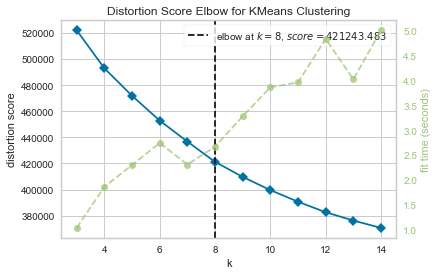

In [13]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [14]:
if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
#num_clusters = 16

In [15]:
num_clusters

10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_30/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS


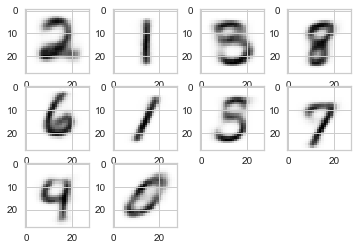

In [16]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
if not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_cluster_center_images(decoded_images, image_filename, cluster_centers)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])   
    img = Image.open(image_filename)
    img.show()
    

# Iteration 2

In [17]:
num_epochs = 2
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"


In [18]:
manual_annotation_file

'manual_annotation_epoch_1.0.csv'

In [19]:
#num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'RUN_ID': 30, 'ID': 1, 'name': 'semi_supervised_classification'}
Warning /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_30/analysis/manual_annotation_epoch_2.csv path does not exist. Creating random prior with

Epoch: 1/77, Nll_loss : 128.73130798339844 KLD:6.362447738647461  Supervised loss:0.0
Epoch: 1/78, Nll_loss : 134.8860626220703 KLD:6.123847961425781  Supervised loss:0.0
Epoch: 1/79, Nll_loss : 133.205078125 KLD:6.289533615112305  Supervised loss:0.0
Epoch: 1/80, Nll_loss : 135.29360961914062 KLD:6.052070617675781  Supervised loss:0.0
Epoch: 1/81, Nll_loss : 127.18778991699219 KLD:6.03543758392334  Supervised loss:0.0
Epoch: 1/82, Nll_loss : 127.10552215576172 KLD:6.2144551277160645  Supervised loss:0.0
Epoch: 1/83, Nll_loss : 135.24554443359375 KLD:5.98316764831543  Supervised loss:0.0
Epoch: 1/84, Nll_loss : 132.26812744140625 KLD:6.253522872924805  Supervised loss:0.0
Epoch: 1/85, Nll_loss : 130.8504638671875 KLD:6.259774208068848  Supervised loss:0.0
Epoch: 1/86, Nll_loss : 128.29287719726562 KLD:6.027263641357422  Supervised loss:0.0
Epoch: 1/87, Nll_loss : 134.29965209960938 KLD:6.134026527404785  Supervised loss:0.0
Epoch: 1/88, Nll_loss : 133.3868865966797 KLD:5.80658817291259

Epoch: 1/173, Nll_loss : 133.73941040039062 KLD:6.194745063781738  Supervised loss:0.0
Epoch: 1/174, Nll_loss : 137.02978515625 KLD:6.155189514160156  Supervised loss:0.0
Epoch: 1/175, Nll_loss : 137.1930389404297 KLD:6.343894004821777  Supervised loss:0.0
Epoch: 1/176, Nll_loss : 130.04141235351562 KLD:6.381817817687988  Supervised loss:0.0
Epoch: 1/177, Nll_loss : 130.8780517578125 KLD:6.7649383544921875  Supervised loss:0.0
Epoch: 1/178, Nll_loss : 133.32608032226562 KLD:6.498274326324463  Supervised loss:0.0
Epoch: 1/179, Nll_loss : 136.970703125 KLD:6.252751350402832  Supervised loss:0.0
Epoch: 1/180, Nll_loss : 138.270751953125 KLD:5.927265644073486  Supervised loss:0.0
Epoch: 1/181, Nll_loss : 135.100830078125 KLD:5.735603332519531  Supervised loss:0.0
Epoch: 1/182, Nll_loss : 131.88621520996094 KLD:5.493399143218994  Supervised loss:0.0
Epoch: 1/183, Nll_loss : 140.4046630859375 KLD:5.722026824951172  Supervised loss:0.0
Epoch: 1/184, Nll_loss : 141.64981079101562 KLD:5.8759579

Epoch: 1/269, Nll_loss : 140.628173828125 KLD:6.3513689041137695  Supervised loss:0.0
Epoch: 1/270, Nll_loss : 142.76388549804688 KLD:6.170951843261719  Supervised loss:0.0
Epoch: 1/271, Nll_loss : 132.49468994140625 KLD:6.547868728637695  Supervised loss:0.0
Epoch: 1/272, Nll_loss : 135.44668579101562 KLD:6.422685623168945  Supervised loss:0.0
Epoch: 1/273, Nll_loss : 134.05665588378906 KLD:6.482148170471191  Supervised loss:0.0
Epoch: 1/274, Nll_loss : 127.50353240966797 KLD:6.334925651550293  Supervised loss:0.0
Epoch: 1/275, Nll_loss : 134.56454467773438 KLD:6.193638324737549  Supervised loss:0.0
Epoch: 1/276, Nll_loss : 131.72772216796875 KLD:6.168977737426758  Supervised loss:0.0
Epoch: 1/277, Nll_loss : 124.61790466308594 KLD:6.2516350746154785  Supervised loss:0.0
Epoch: 1/278, Nll_loss : 129.74252319335938 KLD:6.299871444702148  Supervised loss:0.0
Epoch: 1/279, Nll_loss : 131.64785766601562 KLD:6.249722003936768  Supervised loss:0.0
Epoch: 1/280, Nll_loss : 126.7833251953125 

Epoch: 1/364, Nll_loss : 127.44649505615234 KLD:6.4497480392456055  Supervised loss:0.0
Epoch: 1/365, Nll_loss : 135.34747314453125 KLD:6.2545976638793945  Supervised loss:0.0
Epoch: 1/366, Nll_loss : 127.93424224853516 KLD:6.3604021072387695  Supervised loss:0.0
Epoch: 1/367, Nll_loss : 133.38197326660156 KLD:6.294184684753418  Supervised loss:0.0
Epoch: 1/368, Nll_loss : 134.53787231445312 KLD:6.276978492736816  Supervised loss:0.0
Epoch: 1/369, Nll_loss : 137.24008178710938 KLD:5.897704601287842  Supervised loss:0.0
Epoch: 1/370, Nll_loss : 129.97483825683594 KLD:6.328972339630127  Supervised loss:0.0
Epoch: 1/371, Nll_loss : 133.8280029296875 KLD:6.466493606567383  Supervised loss:0.0
Epoch: 1/372, Nll_loss : 130.77947998046875 KLD:6.329151153564453  Supervised loss:0.0
Epoch: 1/373, Nll_loss : 132.28585815429688 KLD:6.394440650939941  Supervised loss:0.0
Epoch: 1/374, Nll_loss : 131.8731689453125 KLD:6.040933609008789  Supervised loss:0.0
Epoch: 1/375, Nll_loss : 126.2358856201171

Epoch: 1/459, Nll_loss : 128.6971435546875 KLD:6.446250915527344  Supervised loss:0.0
Epoch: 1/460, Nll_loss : 131.29904174804688 KLD:6.611038684844971  Supervised loss:0.0
Epoch: 1/461, Nll_loss : 127.13545227050781 KLD:6.3907928466796875  Supervised loss:0.0
Epoch: 1/462, Nll_loss : 131.62808227539062 KLD:6.593162536621094  Supervised loss:0.0
Epoch: 1/463, Nll_loss : 131.04354858398438 KLD:6.459095478057861  Supervised loss:0.0
Epoch: 1/464, Nll_loss : 132.8508758544922 KLD:6.594742298126221  Supervised loss:0.0
Epoch: 1/465, Nll_loss : 125.64634704589844 KLD:6.329189300537109  Supervised loss:0.0
Epoch: 1/466, Nll_loss : 135.12771606445312 KLD:6.370968818664551  Supervised loss:0.0
Epoch: 1/467, Nll_loss : 122.98402404785156 KLD:6.4403157234191895  Supervised loss:0.0
Epoch: 1/468, Nll_loss : 122.10396575927734 KLD:6.483675003051758  Supervised loss:0.0
Epoch: 1/469, Nll_loss : 133.44435119628906 KLD:6.265191078186035  Supervised loss:0.0
Epoch: 1/470, Nll_loss : 126.34190368652344

Epoch: 1/556, Nll_loss : 132.76380920410156 KLD:6.508866786956787  Supervised loss:0.0
Epoch: 1/557, Nll_loss : 136.58546447753906 KLD:6.343823432922363  Supervised loss:0.0
Epoch: 1/558, Nll_loss : 129.67529296875 KLD:6.251753807067871  Supervised loss:0.0
Epoch: 1/559, Nll_loss : 132.00390625 KLD:6.112156867980957  Supervised loss:0.0
Epoch: 1/560, Nll_loss : 123.80294799804688 KLD:6.661220550537109  Supervised loss:0.0
Epoch: 1/561, Nll_loss : 123.65604400634766 KLD:6.3375725746154785  Supervised loss:0.0
Epoch: 1/562, Nll_loss : 129.39712524414062 KLD:6.385122299194336  Supervised loss:0.0
Epoch: 1/563, Nll_loss : 131.1338653564453 KLD:6.405630111694336  Supervised loss:0.0
Epoch: 1/564, Nll_loss : 128.61032104492188 KLD:6.6301116943359375  Supervised loss:0.0
Epoch: 1/565, Nll_loss : 130.34432983398438 KLD:6.881745338439941  Supervised loss:0.0
Epoch: 1/566, Nll_loss : 121.07711791992188 KLD:6.505163669586182  Supervised loss:0.0
Epoch: 1/567, Nll_loss : 128.4192352294922 KLD:6.46

Epoch: 1/652, Nll_loss : 133.1640625 KLD:6.972196102142334  Supervised loss:0.0
Epoch: 1/653, Nll_loss : 126.0880126953125 KLD:6.778246879577637  Supervised loss:0.0
Epoch: 1/654, Nll_loss : 128.8280029296875 KLD:6.556741714477539  Supervised loss:0.0
Epoch: 1/655, Nll_loss : 132.73638916015625 KLD:6.625333786010742  Supervised loss:0.0
Epoch: 1/656, Nll_loss : 125.70472717285156 KLD:6.617324352264404  Supervised loss:0.0
Epoch: 1/657, Nll_loss : 131.59121704101562 KLD:6.565396308898926  Supervised loss:0.0
Epoch: 1/658, Nll_loss : 127.34623718261719 KLD:6.329927444458008  Supervised loss:0.0
Epoch: 1/659, Nll_loss : 125.509765625 KLD:6.447537422180176  Supervised loss:0.0
Epoch: 1/660, Nll_loss : 127.71847534179688 KLD:6.4737701416015625  Supervised loss:0.0
Epoch: 1/661, Nll_loss : 122.44879913330078 KLD:6.382663726806641  Supervised loss:0.0
Epoch: 1/662, Nll_loss : 130.12286376953125 KLD:6.401084899902344  Supervised loss:0.0
Epoch: 1/663, Nll_loss : 133.75119018554688 KLD:6.451153

Epoch: 1/748, Nll_loss : 128.532470703125 KLD:6.5182929039001465  Supervised loss:0.0
Epoch: 1/749, Nll_loss : 127.34573364257812 KLD:6.861899375915527  Supervised loss:0.0
Epoch: 1/750, Nll_loss : 123.13751983642578 KLD:6.932717323303223  Supervised loss:0.0
Epoch: 1/751, Nll_loss : 120.88261413574219 KLD:6.853501319885254  Supervised loss:0.0
Epoch: 1/752, Nll_loss : 137.22265625 KLD:6.765470504760742  Supervised loss:0.0
Epoch: 1/753, Nll_loss : 119.75399780273438 KLD:6.424638748168945  Supervised loss:0.0
Epoch: 1/754, Nll_loss : 127.41117858886719 KLD:6.768581390380859  Supervised loss:0.0
Epoch: 1/755, Nll_loss : 125.41809844970703 KLD:6.890316963195801  Supervised loss:0.0
Epoch: 1/756, Nll_loss : 129.49337768554688 KLD:6.858452796936035  Supervised loss:0.0
Epoch: 1/757, Nll_loss : 130.63458251953125 KLD:6.686022758483887  Supervised loss:0.0
Epoch: 1/758, Nll_loss : 124.80287170410156 KLD:6.697468280792236  Supervised loss:0.0
Epoch: 1/759, Nll_loss : 124.27003479003906 KLD:6.

Epoch: 1/845, Nll_loss : 129.53512573242188 KLD:6.932544708251953  Supervised loss:0.0
Epoch: 1/846, Nll_loss : 121.42242431640625 KLD:6.873326301574707  Supervised loss:0.0
Epoch: 1/847, Nll_loss : 119.7846450805664 KLD:6.693709373474121  Supervised loss:0.0
Epoch: 1/848, Nll_loss : 121.90058898925781 KLD:6.624837398529053  Supervised loss:0.0
Epoch: 1/849, Nll_loss : 128.6460418701172 KLD:6.775699615478516  Supervised loss:0.0
Epoch: 1/850, Nll_loss : 118.45320892333984 KLD:6.507238388061523  Supervised loss:0.0
Epoch: 1/851, Nll_loss : 132.48052978515625 KLD:6.560613632202148  Supervised loss:0.0
Epoch: 1/852, Nll_loss : 126.5298080444336 KLD:6.158722877502441  Supervised loss:0.0
Epoch: 1/853, Nll_loss : 125.61426544189453 KLD:5.988990783691406  Supervised loss:0.0
Epoch: 1/854, Nll_loss : 132.37872314453125 KLD:6.428704261779785  Supervised loss:0.0
Epoch: 1/855, Nll_loss : 134.33509826660156 KLD:6.58181095123291  Supervised loss:0.0
Epoch: 1/856, Nll_loss : 130.439697265625 KLD:6

Running evaluation after epoch:2 and step:935 
epoch:2 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_30/analysis/
Accuracy: train: [2, 0.11544117647058824]
Accuracy: val: [2, 0.140625]
Accuracy: test: [2, 0.11017628205128205]
Accuracy: train: [2, 128.64188]
Accuracy: val: [2, 128.52701]
Accuracy: test: [2, 127.93273]
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_30/trained_models/
Max test accuracy 0.11017628205128205
Max test reconstruction_loss 127.93273162841797
 [*] Training finished!
Running evaluation after epoch:2 and step:935 
epoch:2 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_30/analysis/
Running evaluation after epoch:2 and step:935 
epoch:2 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32

In [20]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_20/trained_models/SemiSupervisedClassifierMnist.model-1870
 [*] Success to read SemiSupervisedClassifierMnist.model-1870
 [*] Load SUCCESS
Number of steps completed=1870
Number of epochs completed 2.0


In [21]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=20 z_min=-4.5572057 z_max=4.573546
Latent vectors shape (59840, 10)


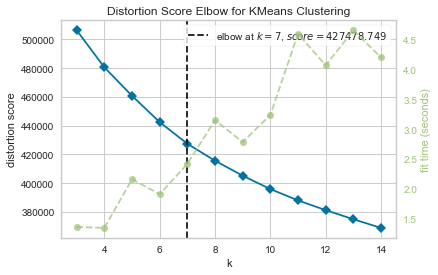

In [22]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_20/trained_models/SemiSupervisedClassifierMnist.model-1870
 [*] Success to read SemiSupervisedClassifierMnist.model-1870
 [*] Load SUCCESS


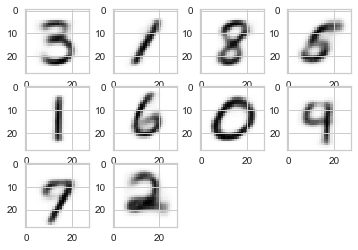

In [23]:
num_clusters = 10
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

# Iteration 3

In [24]:
num_epochs
num_epochs += 1
print(num_epochs)

3


In [25]:
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
print(manual_annotation_file)

manual_annotation_epoch_2.0.csv


In [26]:
#num_epochs += 1
#manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'RUN_ID': 20, 'ID': 1, 'name': 'semi_supervised_classification'}
Warning /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_20/analysis/manual_annotation_epoch_3.csv path does not exist. Creating random prior with

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-2805
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_20/trained_models/SemiSupervisedClassifierMnist.model-2805
 [*] Success to read SemiSupervisedClassifierMnist.model-2805
 [*] Load SUCCESS
Number of steps completed=2805
Number of epochs completed 3.0
run_id=20 z_min=-4.469978299999999 z_max=4.4948487
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence i

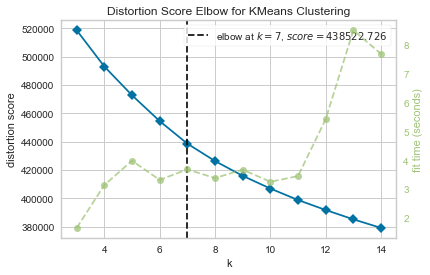

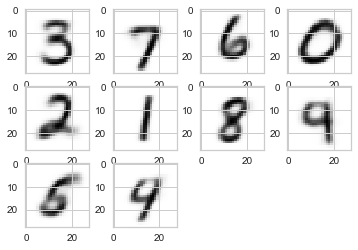

In [27]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

# Iteration 4

In [28]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'RUN_ID': 20, 'ID': 1, 'name': 'semi_supervised_classification'}
Warning /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_20/analysis/manual_annotation_epoch_4.csv path does not exist. Creating random prior with

In [29]:
num_cluster=10
num_clusters=10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_20/trained_models/SemiSupervisedClassifierMnist.model-3740
 [*] Success to read SemiSupervisedClassifierMnist.model-3740
 [*] Load SUCCESS
Number of steps completed=3740
Number of epochs completed 4.0
run_id=20 z_min=-4.2160816 z_max=4.4657849999999994
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence 

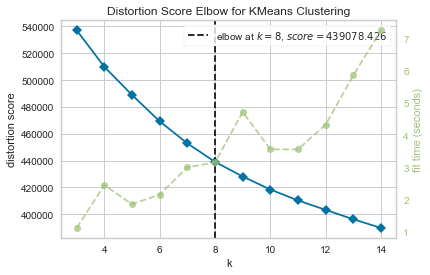

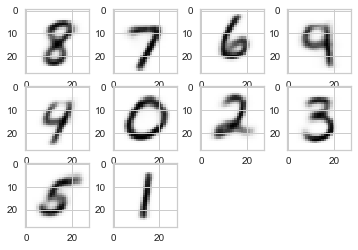

In [30]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

# iteration 5

In [31]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'RUN_ID': 20, 'ID': 1, 'name': 'semi_supervised_classification'}
Warning /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_20/analysis/manual_annotation_epoch_5.csv path does not exist. Creating random prior with

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_20/trained_models/SemiSupervisedClassifierMnist.model-4675
 [*] Success to read SemiSupervisedClassifierMnist.model-4675
 [*] Load SUCCESS
Number of steps completed=4675
Number of epochs completed 5.0
run_id=20 z_min=-4.2293773 z_max=4.4016743
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illega

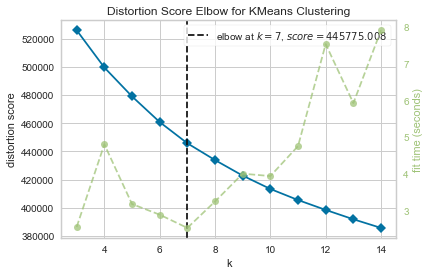

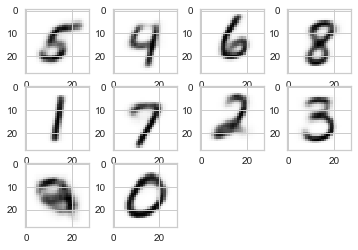

In [32]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [141]:
num_epochs

9